In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import xpart as xp
import yaml
import matplotlib.patches as patches
import xobjects as xo
from scipy.optimize import least_squares
import cv2

def solve_ellipse_equation(x, px):
    num_points = len(x)
    print(len(x))
    # Create the coefficient matrix A
    A = np.vstack((x**2, x*px, px**2)).T
    # Create the constant vector B
    # Use SVD to solve the overdetermined system of equations
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    area = s[0]*s[1]/(len(x))
    points = np.column_stack((x, px)).astype(np.float32)
    ellipse = cv2.fitEllipse(points)
    _, axes, _ = ellipse
    a = max(axes)
    b = min(axes)
    # Calculate the area of the ellipse
    area = np.pi * a * b
    B = np.ones(num_points)*np.sqrt(area**2)/np.pi/4
    V = VT.T
    S_inv = np.zeros_like(V.T)
    S_inv[:num_points, :num_points] = np.diag(1.0 / s)
    coeffs = V @ S_inv @ U.T @ B
    A_coeff, B_coeff, C_coeff = coeffs
    return A_coeff, B_coeff/2, C_coeff

def plotLatticeSeries(ax, twiss, element_name, series, height=1., v_offset=0., color='r',alpha=0.5):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (twiss_b1['s', element_name]-aux['length']*0, v_offset-height/2.),   # (x,y)
        aux['length'],          # width
        height,          # height
        color=color, alpha=alpha
    )
    )
    return;

def getbeta(w,pw):
    U, s, V = np.linalg.svd(np.vstack((w, pw)))
    N = U@np.diag(s)
    scaling = np.abs(1/(np.linalg.det(N)))
    theta = np.arctan2(-N[0,1],N[0,0])
    c = np.cos(theta)
    sin = np.sin(theta)
    R = np.array([[c,sin],[-sin,c]])
    W = np.dot(N,R)
    betaw = W[0,0]**2*scaling
    alfw = -W[1,0]*W[0,0]*scaling
    return betaw,alfw

def get_normalized_phase_space(x, px, beta, alpha, scale):
    P = np.array([[np.sqrt(beta), 0],[-alpha/np.sqrt(beta), 1/np.sqrt(beta)]])
    X =np.array([x,px])
    return np.linalg.inv(P)@X*scale
def algebraic_ellipse_fit(x,px):
    # Algebraic ellipse equation: Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0

    # Prepare the data for fitting
    x, y = x, px
    x2 = x * x
    y2 = y * y
    xy = x * y
    ones = np.ones_like(x)

    # Stack the data to create the coefficient matrix for the ellipse parameters
    A = np.column_stack((x2, xy, y2, x, y, ones))

    # Function to compute the algebraic equation of the ellipse
    def ellipse_equation(params, x, y):
        A, B, C = params
        return A * x * x + B * x * y + C * y * y  - 3.8662332676249253e-10

    # Initial guess for the ellipse parameters (A, B, C, D, E, F)
    initial_guess = (1,-2,170)

    # Use least squares to fit the ellipse parameters
    result = least_squares(ellipse_equation, initial_guess, args=(x, y),ftol = 1e-15, xtol = 1e-15, gtol = 1e-15)

    # Retrieve the optimized parameters
    A_fit, B_fit, C_fit = result.x

    # Convert the fitted parameters to ellipse parameters (center, axes, and rotation angle)
    

    return A_fit, B_fit, C_fit
# %%
ctx = xo.ContextCpu()

In this snippet we will look at the optics quantities of the `ARC`.

The big difference with respect to the previous snippet is that we will use the `twiss` method: in this case the reference system is the one of the beam.
This is the reference system that is used in the vast majority of the cases.

Our task is to understand how the twiss quantities can be retrieved and to see how the LHC arc works.

We start by loading the collider from the json file, as always. Then we call the twiss method on the lhcb1 line.

In [2]:
collider = xt.Multiline.from_json('../data/collider.json')
collider.build_trackers()
my_dict = collider.lhcb1.to_dict()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
twiss_b1 = collider['lhcb1'].twiss()

We can see, for example, the columns of the twiss dataframe, which contain several important quantities.

In [4]:
print(twiss_b1.cols)
print('The beta functions are', twiss_b1['betx'], twiss_b1['bety'])
print('The names of the elements are ', twiss_b1['name'])

<name s x px y py zeta delta ptau betx bety alfx alfy gamx gamy dx dpx dy dpy dx_zeta dy_zeta betx1 bety1 betx2 bety2 mux muy muzeta nux nuy nuzeta W_matrix dzeta dmux dmuy>
The beta functions are [121.56685712 121.56685712  49.91606224 ... 219.9589056  121.56685944
 121.56685944] [218.58364143 218.58364143 340.12636401 ... 135.87219848 218.58385168
 218.58385168]
The names of the elements are  ['ip3' 'drift_0' 'mcbwv.4r3.b1_entry' ... 'drift_6653' 'lhcb1ip3_p_'
 '_end_point']


Now we can plot the beta functions in the ARC together with dipole and quadrupole magnets.
The convention is the following:
- The `dipole` magnets are in `blue`;
- The `quadrupole` magnets are in `red`;
The height of the each element is proportional to the integrated strength of the element.
We are now going to look at `ARC34` .

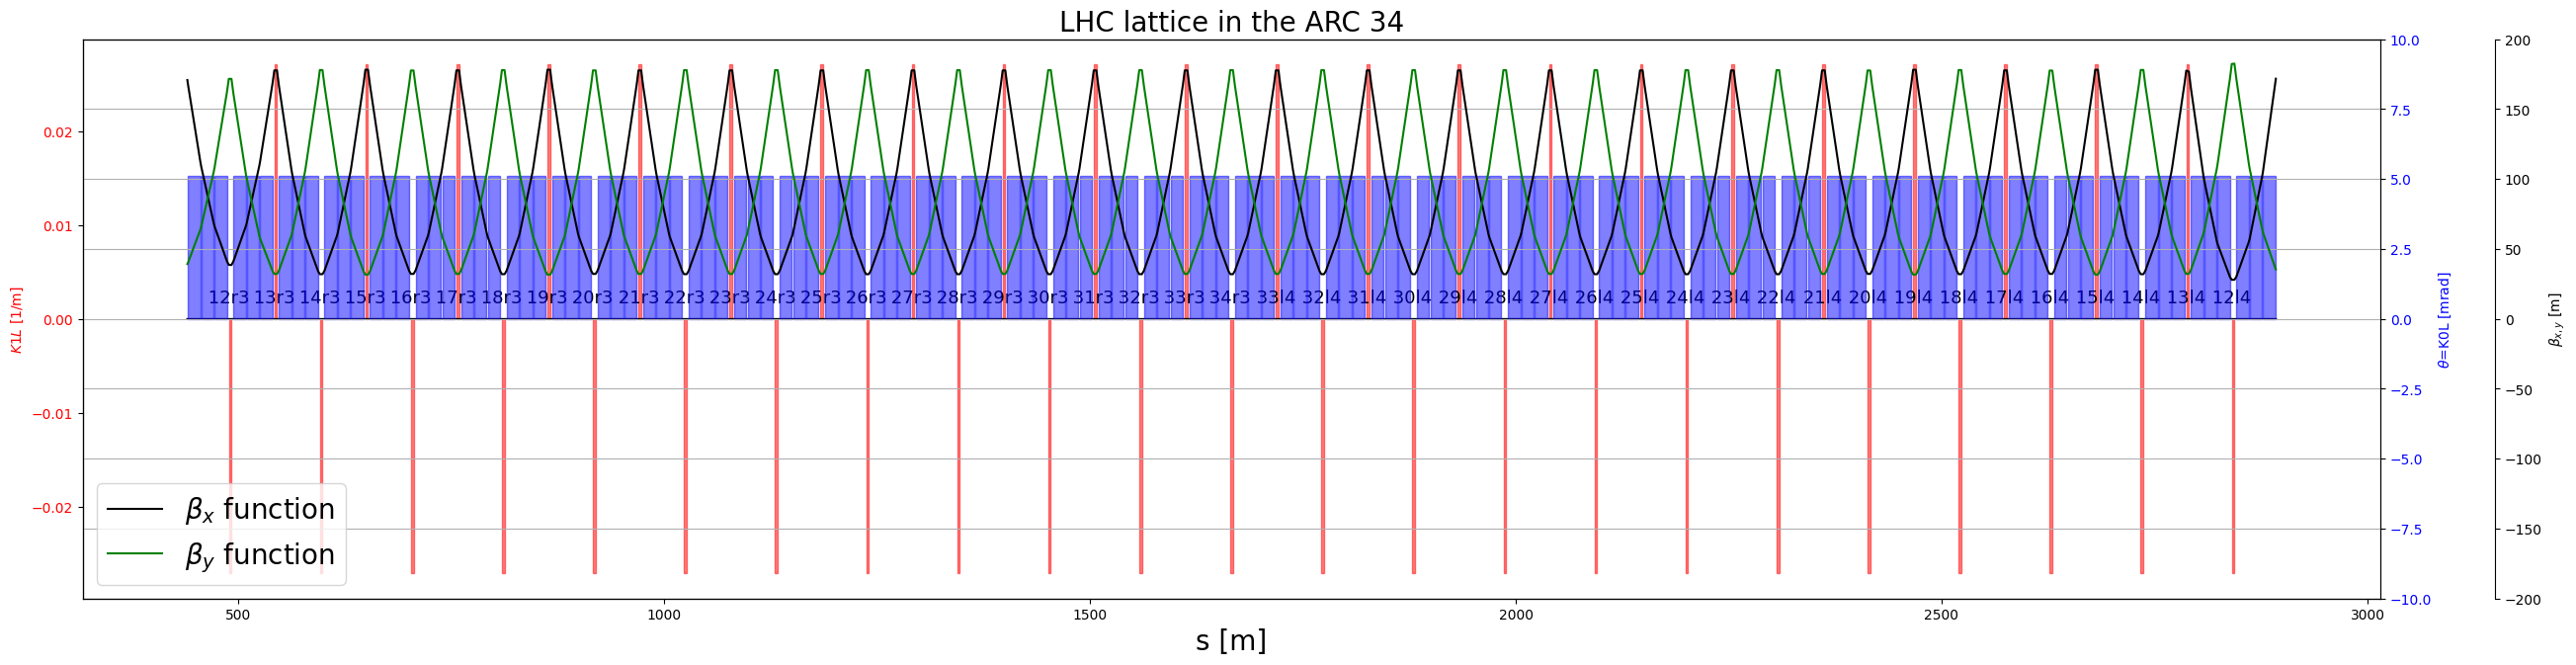

In [5]:
fig = plt.figure(figsize=(30,25))
fontsize = 20
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'],
         0*twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'],'k')
for ii in (twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['name']):
    if((ii.startswith('mq.')) and ii.endswith('b1')):
        aux =my_dict['elements'][ii]
        k1l = my_dict['elements'][ii]['k1']*my_dict['elements'][ii]['length']
        #print(ii, k1l)
        plotLatticeSeries(plt.gca(),twiss_b1, ii, aux, height=k1l, v_offset=k1l/2, color='red')
        # add a label for each quadrupole on top of it with its name
        name = ' '+ii.split('.')[1]+' '
        plt.gca().text(twiss_b1['s', ii], np.abs(k1l)/12, 
                       name, fontsize=13, color='black', horizontalalignment='center', verticalalignment='center')
ax1.set_ylabel(r'$K1L$ [1/m]', color='red')
ax1.tick_params(axis='y', labelcolor='red')
FODO_cell_length = twiss_b1['s','mq.28l2.b1']-twiss_b1['s','mq.30l2.b1']
ax2 = ax1.twinx() 
ax2.set_ylim(-10,10)
for ii in (twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['name']):
    if((ii.startswith('mb.')) and ii.endswith('b1')):
        aux =my_dict['elements'][ii]
        kl = my_dict['elements'][ii]['k0']*my_dict['elements'][ii]['length']
        plotLatticeSeries(plt.gca(),twiss_b1, ii, aux, height=kl*1000, v_offset=kl/2*1000, color='blue')
color = 'blue'
ax2.set_ylabel(r'$\theta$=K0L [mrad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('LHC lattice in the ARC 34', fontsize = fontsize)
color = 'k'
ax3 = ax1.twinx() 
ax3.set_ylim(-200,200)
ax3.spines.right.set_position(("axes", 1.05))
plt.gca().plot(twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'],
               twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['betx'],'k',label=r'$\beta_{x}$ function')
plt.gca().plot(twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'],
               twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['bety'],'green',label=r'$\beta_{y}$ function')
ax3.set_ylabel(r'$\beta_{x,y}$ [m]', color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.legend(fontsize = fontsize)
ax1.set_xlabel('s [m]', fontsize = fontsize)
plt.grid()

First of all some basic comments:
- An LHC `FODO` cell is defined from a defocusing quadrupole to the next defocusing quadrupole and it's length is 106.9 m;
- There are `23 FODO cells in an ARC`;
- Each `dipole kicks` by `5mrad`, so that, with 1232 dipoles around the machine, we get to 2pi (a circle);
- The `beta function` should be a `periodic` function, and this is (almost) the case;
- The beta function in x is opposite to the beta function in y, as expected since the 
`FODO cell focuses in one plane and defocuses in the other`;
Then some questions:
- `All the quadrupoles have the same integrated strength` (absolute value), but the beta function is not the same in all the FODO cells (look at the first and the last cell). Why?
- It is easy to predict the dipolar kick (we must make a circle), but what about the quadrupolar kick? How can we predict it?

The first question requires a bit of knowledge on the ARC and how it is controlled. 

Each ARC is powered by a `single power supply`, therefore all the quadrupoles in the ARC have the same integrated strength.
When multiple components of the machine need to be controlled all together we use something called `knob`. By changing the value of a
knob we can do several things. For example some knobs change the `crossing angle` at the IP, others help us with the `chromaticity` and so on.
By printing out the elements in the ARC you can discover something interesting, some `trim` quadrupoles (mqt):

In [6]:
for ii in (twiss_b1.rows['s.arc.34.b1':'mq.19r3.b1', ]['name']):
    if((ii.startswith('mqt.')) and ii.endswith('b1')):
        aux =my_dict['elements'][ii]
        k1l_t = my_dict['elements'][ii]['k1']*my_dict['elements'][ii]['length']
        print('Name: ',ii,',k1L: ', k1l_t)

Name:  mqt.12r3.b1 ,k1L:  0.00096377579775688
Name:  mqt.13r3.b1 ,k1L:  -0.0010851318579824516
Name:  mqt.14r3.b1 ,k1L:  -8.403669711554023e-05
Name:  mqt.15r3.b1 ,k1L:  -3.333926562941485e-05
Name:  mqt.16r3.b1 ,k1L:  -8.403669711554023e-05
Name:  mqt.17r3.b1 ,k1L:  -3.333926562941485e-05
Name:  mqt.18r3.b1 ,k1L:  -8.403669711554023e-05
Name:  mqt.19r3.b1 ,k1L:  -3.333926562941485e-05


You can see that the first two (and try to repeat the exercise for the last two) have a different integrated strength!

This is because the first (and last) are use to match the beta function at the entrance (and exit) of the ARC.
All the other ones are controlled by the following knobs:

In [7]:
# Defocusing quadrupoles
print(collider.vars['kqtd.a34b1']._find_dependant_targets())
# Focusing quadrupoles
print(collider.vars['kqtf.a34b1']._find_dependant_targets())

[vars['kqtd.a34b1'], eref['lhcb1']['mqt.20r3.b1'].k1, eref['lhcb1']['mqt.18l4.b1'], eref['lhcb1']['mqt.14l4.b1'], eref['lhcb1']['mqt.18r3.b1'], eref['lhcb1']['mqt.20l4.b1'].k1, eref['lhcb1']['mqt.16l4.b1'].k1, eref['lhcb1']['mqt.18r3.b1'].k1, eref['lhcb1']['mqt.14r3.b1'].k1, eref['lhcb1']['mqt.16r3.b1'].k1, eref['lhcb1']['mqt.16r3.b1'], eref['lhcb1'], eref['lhcb1']['mqt.14r3.b1'], eref['lhcb1']['mqt.20r3.b1'], eref['lhcb1']['mqt.20l4.b1'], eref['lhcb1']['mqt.16l4.b1'], eref['lhcb1']['mqt.14l4.b1'].k1, eref['lhcb1']['mqt.18l4.b1'].k1]
[vars['kqtf.a34b1'], eref['lhcb1']['mqt.21r3.b1'], eref['lhcb1']['mqt.15r3.b1'].k1, eref['lhcb1']['mqt.17l4.b1'], eref['lhcb1']['mqt.15l4.b1'].k1, eref['lhcb1']['mqt.17l4.b1'].k1, eref['lhcb1']['mqt.21l4.b1'], eref['lhcb1']['mqt.15r3.b1'], eref['lhcb1']['mqt.19l4.b1'].k1, eref['lhcb1']['mqt.19r3.b1'], eref['lhcb1']['mqt.21l4.b1'].k1, eref['lhcb1'], eref['lhcb1']['mqt.17r3.b1'], eref['lhcb1']['mqt.17r3.b1'].k1, eref['lhcb1']['mqt.21r3.b1'].k1, eref['lhcb1']

The first two are controlled by the following knobs (and you can guess the knobs for the last two):

In [8]:
print(collider.vars['kqt12.r3b1']._find_dependant_targets())
print(collider.vars['kqt13.r3b1']._find_dependant_targets())

[vars['kqt12.r3b1'], eref['lhcb1'], eref['lhcb1']['mqt.12r3.b1'], eref['lhcb1']['mqt.12r3.b1'].k1]
[vars['kqt13.r3b1'], eref['lhcb1'], eref['lhcb1']['mqt.13r3.b1'], eref['lhcb1']['mqt.13r3.b1'].k1]


Now we can try to answer the second question. A similar treatment of the problem is found in many books, 
for example in A. Wolski's book.

The idea is to equate the transfer matrix in terms of the FODO lattice parameters (k,L) 
and the transfer matrix in terms of the beta functions.
This leads to the following stability condition:

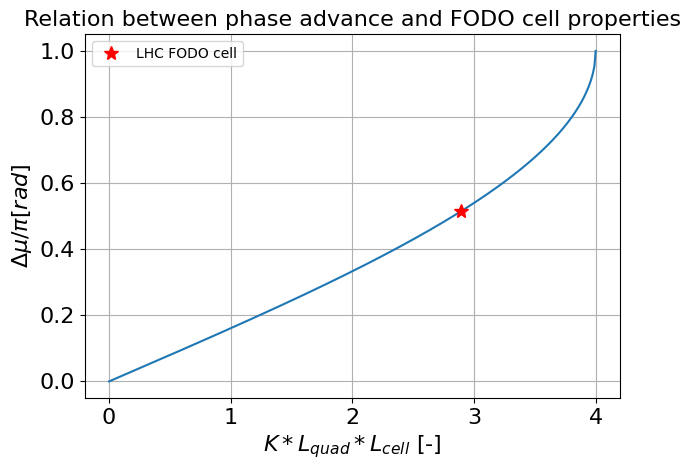

In [9]:
x= np.arange(0,4.01,0.01)
y=2*np.arcsin(x/4)/np.pi
FODO_cell_length = twiss_b1['s','mq.28l2.b1']-twiss_b1['s','mq.30l2.b1']
LHCFODO = np.abs(k1l)*FODO_cell_length
y_LHC = 2*np.arcsin(LHCFODO/4)/np.pi
fig, ax1 = plt.subplots()
ax1.plot(x,y,'-')
ax1.set_ylabel("$\Delta \mu / \pi [rad]$", fontsize=16)
ax1.set_xlabel("$K*L_{quad}*L_{cell}$ [-]", fontsize=16)
ax1.grid()
ax1.tick_params(axis='both', labelsize=16)
phase_advance = np.abs((twiss_b1['mux','mq.30l2.b1']-twiss_b1['mux','mq.28l2.b1']))
ax1.plot(LHCFODO, y_LHC, '*', markersize=10, color='red', label='LHC FODO cell')
ax1.set_title('Relation between phase advance and FODO cell properties', fontsize=16)
ax1.legend(fontsize=10)
plt.tight_layout()

So regarding the LHC FODO each cell provides a ~pi/2 phase advance.

From the same equation we can also impose that the beta function maximum and minimum are small enough to avoid the
beam pipe to be too large. In a FODO cell the average beta function is minimized whern each cell provides a phase advance of pi/2.

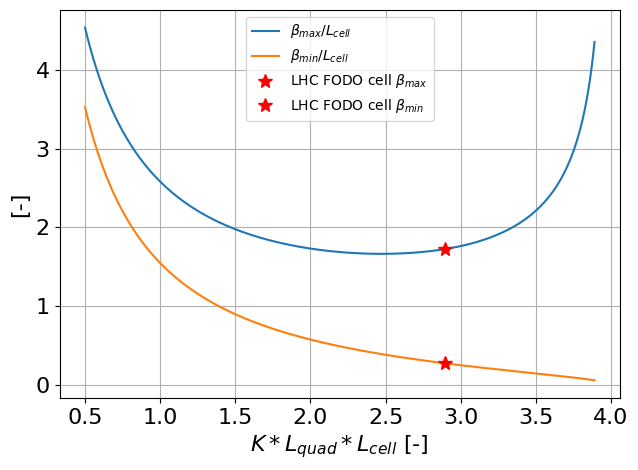

In [10]:
x=np.arange(0.5,3.90,0.01)
betamax=(1+(x/4))/(np.sin(2*np.arcsin(x/4)))
betamin=(1-(x/4))/(np.sin(2*np.arcsin(x/4)))
x_LHC = np.abs(k1l)*FODO_cell_length
betamax_LHC=(1+(x_LHC/4))/(np.sin(2*np.arcsin(x_LHC/4)))
betamin_LHC=(1-(x_LHC/4))/(np.sin(2*np.arcsin(x_LHC/4)))
fig, ax1 = plt.subplots()
ax1.plot(x,betamax,'-',label=r"$\beta_{max}/L_{cell}$")
ax1.plot(x,betamin,'-',label=r"$\beta_{min}/L_{cell}$")
ax1.plot(x_LHC,betamax_LHC, '*', markersize=10, color='red', label=r'LHC FODO cell $\beta_{max}$')
ax1.plot(x_LHC,betamin_LHC, '*', markersize=10, color='red', label=r'LHC FODO cell $\beta_{min}$')
ax1.set_ylabel("[-]", fontsize=16)
ax1.set_xlabel("$K*L_{quad}*L_{cell}$ [-]", fontsize=16)
plt.grid()
plt.legend()
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout() 

Now we can try to question ourselves: the arc itself is a periodic structure, `can we find the beta functions`?

To do this we need to build a new line with the arc only. We can do this by using the following:

In [11]:
start = 'mq.15r3.b1_entry'
end = 'mq.15l4.b1_entry'
collider.vars['i_oct_b1'] = -250
for ii in (twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['name']):
    if((ii.startswith('ms.')) and (ii.endswith('b1'))):
        collider['lhcb1'].element_dict[ii].knl[2] = 0
        print(collider['lhcb1'].element_dict[ii])
# %%
my_line = xt.Line(
    elements=(collider['lhcb1'].element_dict),
    element_names=twiss_b1.rows[start:end, ]['name'])
my_line.build_tracker()

Multipole(_order=2, inv_factorial_order=0.5, length=0.369, hxl=0.0, hyl=0.0, radiation_flag=0, knl=[0. 0. 0.], ksl=[0. 0. 0.], _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=2, inv_factorial_order=0.5, length=0.369, hxl=0.0, hyl=0.0, radiation_flag=0, knl=[0. 0. 0.], ksl=[0. 0. 0.], _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=2, inv_factorial_order=0.5, length=0.369, hxl=0.0, hyl=0.0, radiation_flag=0, knl=[0. 0. 0.], ksl=[0. 0. 0.], _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=2, inv_factorial_order=0.5, length=0.369, hxl=0.0, hyl=0.0, radiation_flag=0, knl=[0. 0. 0.], ksl=[0. 0. 0.], _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=2, inv_factorial_order=0.5, length=0.369, hxl=0.0, hyl=0.0, radiation_flag=0, knl=[0. 0. 0.], ksl=[0. 0. 0.], _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=2, inv_factorial_order=0.5, length=0.369, h

Notice that we skipped the first and last quadrupoles, since they are used to match the beta function 
at the entrance and exit of the arc and therefore would not give us a periodic solution.

We can twiss (in 4D) the line and plot the beta functions. 

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


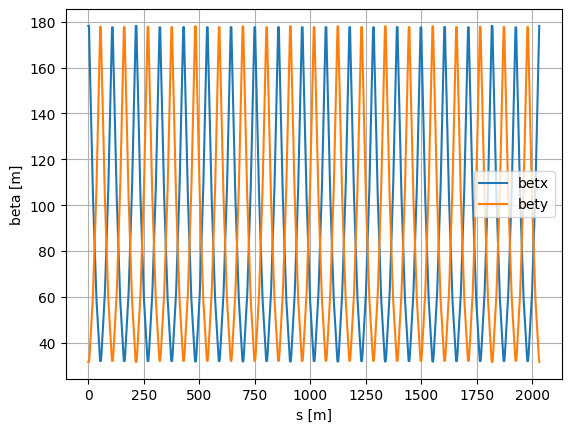

In [12]:
ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
twiss_b1_line = my_line.twiss(particle_ref=ref, method='4d')
plt.plot(twiss_b1_line.s,twiss_b1_line.betx, label='betx')
plt.plot(twiss_b1_line.s,twiss_b1_line.bety, label='bety')
plt.xlabel('s [m]')
plt.ylabel('beta [m]')
plt.grid()
plt.legend()

Indeed we recovered the periodic solution.

Now something more interesting: can we find the beta functions of the arc by using the tracking?

In Xsuite the twiss is a tracking anyway, so we should be able to do this. 

The procedure is the following:
- We launch one particle, and since the motion is uncoupled we can directly input a starting x and y coordinate;
- This particle is tracked for several turns, and this will fill the phase space ellipse in both planes since at each
turn the particle will reach a slightly different position (this happens because the tune is not an integer);
- At this point from the turn by turn coordinates we can calculate the beta functions via `SVD`.

In [13]:
betx = twiss_b1_line['betx'][0]
bety = twiss_b1_line['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6
particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
# %%
x = 1e-6
y = 1e-6
aux = xp.Particles(ctx = ctx,mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x = x, px = 0, y = y, py = 0)

To define the ellipse we need 5 points, so we need to track the particle for 5 turns.

In [14]:
n_turns = 5
xs = []
pxs = []
ys = []
pys = []
for ii in range(n_turns):
    my_line.track(aux, num_turns=1)
    xs.append(ctx.nparray_from_context_array(aux.x).copy()[0])
    pxs.append(ctx.nparray_from_context_array(aux.px).copy()[0])
    ys.append(ctx.nparray_from_context_array(aux.y).copy()[0])
    pys.append(ctx.nparray_from_context_array(aux.py).copy()[0])
xs = np.array(xs)
pxs = np.array(pxs)
ys = np.array(ys)
pys = np.array(pys)

Now we call the solver function, which will return the beta functions and the alpha.
To do this we need to solve a system of equations, which is done via `SVD`.

In [15]:
gamx_fit, alfx_fit, betx_fit =  solve_ellipse_equation(np.reshape(xs,n_turns),np.reshape(pxs,n_turns))
gamy_fit, alfy_fit, bety_fit =  solve_ellipse_equation(np.reshape(ys,n_turns),np.reshape(pys,n_turns))
print('Tracking betx:',betx_fit,', alfa:',alfx_fit)
print('Twiss betx:',twiss_b1_line.betx[0],', alfa:',twiss_b1_line.alfx[0])
print('Tracking bety:',bety_fit,', alfa:',alfy_fit)
print('Twiss bety:',twiss_b1_line.bety[0],', alfa:',twiss_b1_line.alfy[0])

5
5
Tracking betx: 178.1633777109786 , alfa: -2.426077592815644
Twiss betx: 178.16337946272682 , alfa: -2.4260776489936196
Tracking bety: 31.602451305950005 , alfa: 0.47545677507260803
Twiss bety: 31.60245129708153 , alfa: 0.47545676923969643


We retrieved the beta functions and the alpha, which are in good agreement with the twiss, and this was all 
thanks to the tracking. It is remarkable to notice that the tracking is not only a tool to simulate the motion
of the particles, but it can also be used to retrieve the optics parameters of the machine.